In [1]:
import tensorflow as tf
import keras
from tensorflow import keras
import kagglehub


from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

import os
import cv2
import numpy as np
from imgaug import augmenters as iaa

from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [2]:
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
train_images = os.path.join(path, 'asl_alphabet_train', 'asl_alphabet_train')

# Augmentation Sequence
augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Rotate images within [-10, 10] degrees
    iaa.AddToBrightness((-2, 2)),  # Adjust brightness
    iaa.AdditiveGaussianNoise(scale=(0, 0.001 * 255)),  # Add Gaussian noise
    iaa.Crop(percent=(0, 0.1))  # Crop by up to 10% from each side
])
# Function to convert BGR to RGB for display
def convert_bgr_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Data loading and augmentation
def get_data_with_augmentation(data_dir):
    images = []
    labels = []

    dir_list = os.listdir(data_dir)
    for i, label in enumerate(dir_list):
        print("Obtaining and augmenting images of", label, "...")
        for image in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, image)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (32, 32))
            
            # Append the original image
            images.append(img)
            labels.append(i)

            # Apply augmentations
            img_augmented = augmentation(images=[img] * 2)  
            images.extend(img_augmented)
            labels.extend([i] * len(img_augmented))

    return np.array(images), np.array(labels)

# Loading data with augmentation
X, y = get_data_with_augmentation(train_images)

print("Dataset Size (including originals and augmentations):", len(X))


Obtaining and augmenting images of R ...
Obtaining and augmenting images of U ...
Obtaining and augmenting images of I ...
Obtaining and augmenting images of N ...
Obtaining and augmenting images of G ...
Obtaining and augmenting images of Z ...
Obtaining and augmenting images of T ...
Obtaining and augmenting images of S ...
Obtaining and augmenting images of A ...
Obtaining and augmenting images of F ...
Obtaining and augmenting images of O ...
Obtaining and augmenting images of H ...
Obtaining and augmenting images of del ...
Obtaining and augmenting images of nothing ...
Obtaining and augmenting images of space ...
Obtaining and augmenting images of M ...
Obtaining and augmenting images of J ...
Obtaining and augmenting images of C ...
Obtaining and augmenting images of D ...
Obtaining and augmenting images of V ...
Obtaining and augmenting images of Q ...
Obtaining and augmenting images of X ...
Obtaining and augmenting images of E ...
Obtaining and augmenting images of B ...
Obta

In [3]:
# Split into Training and Test
import sklearn
from sklearn.model_selection import train_test_split

labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 
    'E', 'B', 'K', 'L', 'Y', 'P', 'W'
]

X = np.array(X)
y = np.array(y)

# Normalizing
X_normalized = X.astype('float32') / 255.0

# Training and Test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Shapes
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")


# Encoding
y_train_encoded = to_categorical(y_train, num_classes=len(labels))
y_test_encoded = to_categorical(y_test, num_classes=len(labels))

y_train_encoded
y_test_encoded


Training data shape: (182700, 32, 32, 3), Test data shape: (78300, 32, 32, 3)
Training labels shape: (182700,), Test labels shape: (78300,)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
classes = 29
batch = 64
epochs = 10
learning_rate = 0.001

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
from tensorflow.keras.regularizers import l2

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(classes, activation='softmax'))


early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=2,              
    restore_best_weights=True 
)
from tensorflow.keras.optimizers import SGD

sgd = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

# Compile the model with SGD
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with SGD
history = model.fit(
    X_train, 
    y_train_encoded, 
    batch_size=batch, 
    epochs=epochs, 
    validation_split=0.3, 
    shuffle=True, 
    verbose=1, 
    callbacks=[early_stopping]
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 59s 29ms/step - accuracy: 0.4418 - loss: 13.3422 - val_accuracy: 0.8477 - val_loss: 6.7652
Epoch 2/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.8891 - loss: 5.6379 - val_accuracy: 0.8014 - val_loss: 3.5434
Epoch 3/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.9462 - loss: 2.6574 - val_accuracy: 0.9730 - val_loss: 1.5155
Epoch 4/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.9678 - loss: 1.3205 - val_accuracy: 0.9666 - val_loss: 0.8363
Epoch 5/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 57s 28ms/step - accuracy: 0.9766 - loss: 0.7120 - val_accuracy: 0.9557 - val_loss: 0.5363
Epoch 6/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.9818 - loss: 0.4241 - val_accuracy: 0.9717 - val_loss: 0.3401
Epoch 7/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 58s 29ms/step - accuracy: 0.9851 - loss: 0.2876 - val_accuracy: 0.9757 - val_loss: 0.2580
Epoch 8/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 61s 31ms/step - accuracy: 0.9869 

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9901 - loss: 0.1464
Test Loss: 0.1456, Test Accuracy: 0.9900


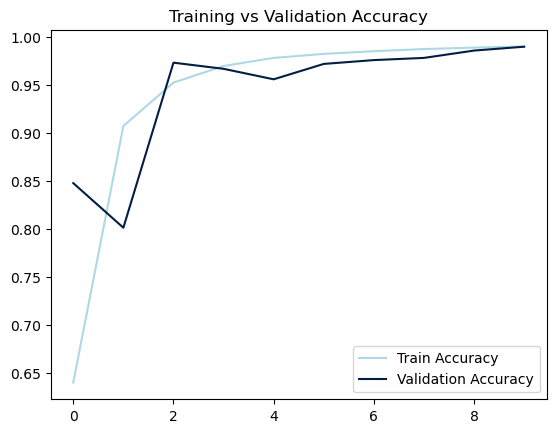

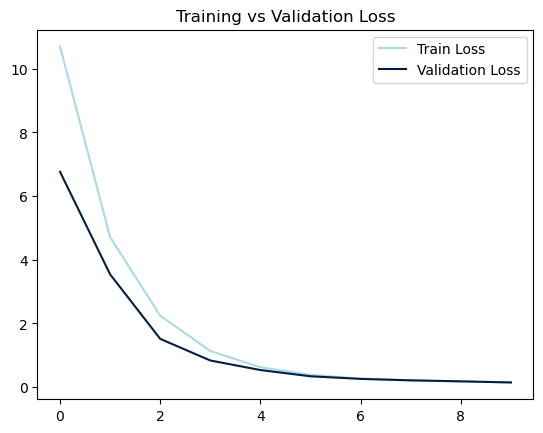

In [7]:
# Training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#ADD8E6')  # Training color
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#041E42')  # Validation color
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Training and validation loss
plt.plot(history.history['loss'], label='Train Loss', color='#ADD8E6')  # Training color
plt.plot(history.history['val_loss'], label='Validation Loss', color='#041E42')  # Validation color
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [8]:
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)

# Classification report
print(classification_report(y_test_classes, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2642
           1       1.00      0.92      0.96      2682
           2       0.99      1.00      0.99      2622
           3       0.96      1.00      0.98      2806
           4       1.00      0.99      0.99      2757
           5       1.00      1.00      1.00      2643
           6       0.99      0.99      0.99      2667
           7       0.99      0.99      0.99      2755
           8       1.00      0.99      0.99      2733
           9       1.00      1.00      1.00      2569
          10       0.99      1.00      1.00      2660
          11       0.99      1.00      0.99      2702
          12       1.00      0.99      1.00      2704
          13       1.00      1.00      1.00      2736
          14       0.99      1.00      0.99      2619
          15       1.00      0.96      0.98      2747
          16       1.00      1.00    

In [1]:
print(conf_matrix)

NameError: name 'conf_matrix' is not defined

In [9]:
model.save('labeled2.h5')

In [11]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = '/Users/hannahkim/Downloads/archive-2/asl_alphabet_test/asl_alphabet_test/B_test.jpg'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (32, 32))
img_rgb = convert_bgr_to_rgb(img_resized)
img_normalized = img_rgb.astype('float32') / 255.0
img_batch = np.expand_dims(img_normalized, axis=0)
y_pred = model.predict(img_batch)

y_pred_class = np.argmax(y_pred, axis=1)[0]

labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'del', 'nothing', 'space', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 
    'E', 'B', 'K', 'L', 'Y', 'P', 'W'
]

predicted_label = labels[y_pred_class]

print(f"The predicted class for the image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The predicted class for the image is: B
